### Need to change cells:
* Calculate factors
* Calculating Factor's Values
* Plotting Prices and Factor's values

In [3]:
import pandas as pd
import os
import time
import patoolib
import gzip
import shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import openpyxl

In [464]:
patoolib.extract_archive(r"L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\EURUSD_all_files.pkl.gz", 
                         outdir=r"L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\\")

patool: Extracting L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\EURUSD_all_files.pkl.gz ...
patool: running "C:\Program Files\7-Zip\7z.EXE" e -oL:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\\ -- L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\EURUSD_all_files.pkl.gz


PatoolError: Command `['C:\\Program Files\\7-Zip\\7z.EXE', 'e', '-oL:\\Raw_1_sec_Bar_Data\\FX\\EURUSD\\Pickle\\\\', '--', 'L:\\Raw_1_sec_Bar_Data\\FX\\EURUSD\\Pickle\\EURUSD_all_files.pkl.gz']' returned non-zero exit status 255

In [514]:
df = pd.read_pickle(r"L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\EURUSD_all_files.pkl")
analyzed_df = df["2018-02"]

In [466]:
df.head()

Open      High      Low    Close
DateTime_UTC                                             
2018-02-19 00:00:00  1.241175  1.241175  1.24115  1.24115
2018-02-19 00:00:01  1.241150  1.241175  1.24115  1.24115
2018-02-19 00:00:02  1.241150  1.241150  1.24115  1.24115
2018-02-19 00:00:03  1.241150  1.241150  1.24115  1.24115
2018-02-19 00:00:04  1.241150  1.241150  1.24115  1.24115

### Inspecting one day

In [440]:
analyzed_df["2018-02-23 09:06:58":"2018-02-23 09:07:02"]

Open      High       Low     Close
DateTime_UTC                                               
2018-02-23 09:06:58  1.396425  1.396425  1.396425  1.396425
2018-02-23 09:06:59  1.396425  1.396425  1.396425  1.396425
2018-02-23 09:07:00  1.396425  1.396425  1.396425  1.396425
2018-02-23 09:07:01  1.396425  1.396425  1.396200  1.396225
2018-02-23 09:07:02  1.396225  1.396275  1.396200  1.396200

## Selecting Date and Size

In [722]:
class Trade_Size:
    size = 20000

trading_date = "2018-03"

start_date = "2018-02-19"
end_date = "2019-03-15"

filter_days = []
filter_hours = range(7,20) # UTC timezone
filter_mins = []
filter_secs = []

#analyzed_df = df[trading_date]
analyzed_df = df.loc[start_date:end_date,:]
analyzed_df.head()

Open      High      Low    Close
DateTime_UTC                                             
2018-02-19 00:00:00  1.241175  1.241175  1.24115  1.24115
2018-02-19 00:00:01  1.241150  1.241175  1.24115  1.24115
2018-02-19 00:00:02  1.241150  1.241150  1.24115  1.24115
2018-02-19 00:00:03  1.241150  1.241150  1.24115  1.24115
2018-02-19 00:00:04  1.241150  1.241150  1.24115  1.24115

### Resampling into 1 Minute bars

In [723]:
resample_interval = "15T"

min_1_low = analyzed_df.loc[:,"Low"].resample(resample_interval).apply(np.min)
min_1_high = analyzed_df.loc[:,"High"].resample(resample_interval).apply(np.max)
min_1_open = analyzed_df.loc[:,"Open"].resample(resample_interval).first()
min_1_close = analyzed_df.loc[:,"Close"].resample(resample_interval).last()
#min_1_Trading_date_Actual_Time = analyzed_df.loc[:,"Trading_date_Actual_Time"].resample(resample_interval).first()
#min_1_Trading_date_Sequential_Time = analyzed_df.loc[:,"Trading_date_Sequential_Time"].resample(resample_interval).first()

# min_1_analyzed_df = pd.DataFrame.from_dict({"Open":min_1_open,"High":min_1_high,"Low":min_1_low,"Close":min_1_close,
#                                         "Trading_date_Actual_Time":min_1_Trading_date_Actual_Time,
#                                         "Trading_date_Sequential_Time":min_1_Trading_date_Sequential_Time})

min_1_analyzed_df = pd.DataFrame.from_dict({"Open":min_1_open,"High":min_1_high,"Low":min_1_low,"Close":min_1_close})

min_1_analyzed_df.head()

Open      High       Low     Close
DateTime_UTC                                               
2018-02-19 00:00:00  1.241175  1.242025  1.241100  1.241925
2018-02-19 00:15:00  1.241925  1.242100  1.241575  1.241975
2018-02-19 00:30:00  1.241975  1.242700  1.241925  1.242675
2018-02-19 00:45:00  1.242675  1.242900  1.242250  1.242275
2018-02-19 01:00:00  1.242275  1.242775  1.242225  1.242725

### Calculate factors

In [724]:
num_of_std_dev = 2

min_1_analyzed_df["Middle_Band"] = min_1_analyzed_df["Close"].rolling(20).mean()
min_1_analyzed_df["Upper_Band"] = min_1_analyzed_df["Middle_Band"] + \
(min_1_analyzed_df["Close"].rolling(20).std()*num_of_std_dev)
min_1_analyzed_df["Lower_Band"] = min_1_analyzed_df["Middle_Band"] - \
(min_1_analyzed_df["Close"].rolling(20).std()*num_of_std_dev)
min_1_analyzed_df["Prev_Lower_Band"] = min_1_analyzed_df["Lower_Band"].shift(1)
min_1_analyzed_df["Prev_Upper_Band"] = min_1_analyzed_df["Upper_Band"].shift(1)
min_1_analyzed_df["Upper_Lower_Band_Span"] = min_1_analyzed_df["Upper_Band"] - min_1_analyzed_df["Lower_Band"]
min_1_analyzed_df["Candle_High_and_Close_above_U_Band"] = min_1_analyzed_df["Close"] > min_1_analyzed_df["Upper_Band"]
min_1_analyzed_df["Prev_Candle_High_and_Close_above_U_Band"] = min_1_analyzed_df["Candle_High_and_Close_above_U_Band"].shift(1)
min_1_analyzed_df.drop("Candle_High_and_Close_above_U_Band",axis=1,inplace=True)
min_1_analyzed_df["Candle_Low_and_Close_below_L_Band"] = min_1_analyzed_df["Close"] < min_1_analyzed_df["Lower_Band"]
min_1_analyzed_df["Prev_Candle_Low_and_Close_below_L_Band"] = min_1_analyzed_df["Candle_Low_and_Close_below_L_Band"].shift(1)
min_1_analyzed_df.drop("Candle_Low_and_Close_below_L_Band",axis=1,inplace=True)
#min_1_analyzed_df["Is_Prev_Cndl_Up"] = ((min_1_analyzed_df["Close"].shift(1) - min_1_analyzed_df["Open"].shift(1)) >= 0)
#min_1_analyzed_df["Is_Prev_Cndl_Down"] = ((min_1_analyzed_df["Close"].shift(1) - min_1_analyzed_df["Open"].shift(1)) < 0)
min_1_analyzed_df["Five_per_std"] = min_1_analyzed_df["Close"].rolling(5).std()
min_1_analyzed_df["Prev_High"] = min_1_analyzed_df["High"].shift(1)
min_1_analyzed_df["Prev_Low"] = min_1_analyzed_df["Low"].shift(1)
min_1_analyzed_df["Seventy_SMA"] = min_1_analyzed_df["Close"].rolling(70).mean()
min_1_analyzed_df["Prev_5_Per_Seventy_SMA"] = min_1_analyzed_df["Seventy_SMA"].shift(5)
# min_1_analyzed_df["SMA10_vs_SMA20"] = min_1_analyzed_df["SMA10"] - min_1_analyzed_df["SMA20"]
# min_1_analyzed_df["SMA10_vs_SMA20_Shifted"] = min_1_analyzed_df["SMA10_vs_SMA20"].shift(1)
min_1_analyzed_df.head(25)

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 00:00:00  1.241175  1.242025  1.241100  1.241925          NaN   
2018-02-19 00:15:00  1.241925  1.242100  1.241575  1.241975          NaN   
2018-02-19 00:30:00  1.241975  1.242700  1.241925  1.242675          NaN   
2018-02-19 00:45:00  1.242675  1.242900  1.242250  1.242275          NaN   
2018-02-19 01:00:00  1.242275  1.242775  1.242225  1.242725          NaN   
2018-02-19 01:15:00  1.242725  1.243050  1.242425  1.243000          NaN   
2018-02-19 01:30:00  1.243000  1.243050  1.242550  1.242900          NaN   
2018-02-19 01:45:00  1.242900  1.243525  1.242875  1.243425          NaN   
2018-02-19 02:00:00  1.243425  1.243425  1.242875  1.243225          NaN   
2018-02-19 02:15:00  1.243225  1.243225  1.242875  1.243025          NaN   
2018-02-19 02:30:00  1.243025  1.243175  1.242825  1.242925          NaN   
2018-02-19 02:45:00  1.242925  1.242975  1.242425  1.242450          NaN   
2018-02-19 03:00:00  1.242450  1.242700  1.242325  1.242575          NaN   
2018-02-19 03:15:00  1.242575  1.242675  1.242450  1.242550          NaN   
2018-02-19 03:30:00  1.242550  1.242675  1.242225  1.242250          NaN   
2018-02-19 03:45:00  1.242250  1.242425  1.241900  1.242100          NaN   
2018-02-19 04:00:00  1.242100  1.242400  1.241775  1.241975          NaN   
2018-02-19 04:15:00  1.241975  1.242025  1.241725  1.241825          NaN   
2018-02-19 04:30:00  1.241825  1.242025  1.241250  1.241350          NaN   
2018-02-19 04:45:00  1.241350  1.241700  1.241175  1.241575     1.242436   
2018-02-19 05:00:00  1.241575  1.241675  1.241350  1.241575     1.242419   
2018-02-19 05:15:00  1.241575  1.241925  1.241150  1.241400     1.242390   
2018-02-19 05:30:00  1.241400  1.241400  1.240425  1.240750     1.242294   
2018-02-19 05:45:00  1.240750  1.241375  1.240700  1.240950     1.242228   
2018-02-19 06:00:00  1.240950  1.241300  1.240825  1.241175     1.242150   

                     Upper_Band  Lower_Band  Prev_Lower_Band  Prev_Upper_Band  \
DateTime_UTC                                                                    
2018-02-19 00:00:00         NaN         NaN              NaN              NaN   
2018-02-19 00:15:00         NaN         NaN              NaN              NaN   
2018-02-19 00:30:00         NaN         NaN              NaN              NaN   
2018-02-19 00:45:00         NaN         NaN              NaN              NaN   
2018-02-19 01:00:00         NaN         NaN              NaN              NaN   
2018-02-19 01:15:00         NaN         NaN              NaN              NaN   
2018-02-19 01:30:00         NaN         NaN              NaN              NaN   
2018-02-19 01:45:00         NaN         NaN              NaN              NaN   
2018-02-19 02:00:00         NaN         NaN              NaN              NaN   
2018-02-19 02:15:00         NaN         NaN              NaN              NaN   
2018-02-19 02:30:00         NaN         NaN              NaN              NaN   
2018-02-19 02:45:00         NaN         NaN              NaN              NaN   
2018-02-19 03:00:00         NaN         NaN              NaN              NaN   
2018-02-19 03:15:00         NaN         NaN              NaN              NaN   
2018-02-19 03:30:00         NaN         NaN              NaN              NaN   
2018-02-19 03:45:00         NaN         NaN              NaN              NaN   
2018-02-19 04:00:00         NaN         NaN              NaN              NaN   
2018-02-19 04:15:00         NaN         NaN              NaN              NaN   
2018-02-19 04:30:00         NaN         NaN              NaN              NaN   
2018-02-19 04:45:00    1.243565    1.241308              NaN              NaN   
2018-02-19 05:00:00    1.243590    1.241247         1.241308         1.243565   
2018-02-19 05:15:00    1.243634    1.241146         1.241247         1.243590   
2018-02-19 05:30:00    1.243

In [725]:
min_1_analyzed_df.dropna(inplace=True)
min_1_analyzed_df.head(35)

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 18:30:00  1.240950  1.241075  1.240900  1.240925     1.239424   
2018-02-19 18:45:00  1.240925  1.241075  1.240875  1.240875     1.239604   
2018-02-19 19:00:00  1.240875  1.241175  1.240875  1.241025     1.239754   
2018-02-19 19:15:00  1.241025  1.241050  1.240950  1.240950     1.239920   
2018-02-19 19:30:00  1.240950  1.241075  1.240825  1.241075     1.240095   
2018-02-19 19:45:00  1.241075  1.241225  1.240675  1.240800     1.240261   
2018-02-19 20:00:00  1.240800  1.240900  1.240725  1.240825     1.240414   
2018-02-19 20:15:00  1.240825  1.240825  1.240575  1.240575     1.240520   
2018-02-19 20:30:00  1.240575  1.240600  1.240475  1.240575     1.240635   
2018-02-19 20:45:00  1.240575  1.240850  1.240475  1.240650     1.240681   
2018-02-19 21:00:00  1.240650  1.240675  1.240525  1.240600     1.240735   
2018-02-19 21:15:00  1.240600  1.240825  1.240600  1.240750     1.240771   
2018-02-19 21:30:00  1.240750  1.240800  1.240650  1.240750     1.240815   
2018-02-19 21:45:00  1.240750  1.240800  1.240675  1.240750     1.240814   
2018-02-20 16:45:00  1.234275  1.235075  1.233625  1.234825     1.234371   
2018-02-20 17:00:00  1.234825  1.235275  1.234075  1.234975     1.234383   
2018-02-20 17:15:00  1.234975  1.235775  1.234975  1.235425     1.234415   
2018-02-20 17:30:00  1.235425  1.235575  1.234275  1.234275     1.234423   
2018-02-20 17:45:00  1.234275  1.234900  1.234225  1.234425     1.234413   
2018-02-20 18:00:00  1.234425  1.234575  1.233775  1.234025     1.234415   
2018-02-20 18:15:00  1.234025  1.234325  1.233775  1.234075     1.234420   
2018-02-20 18:30:00  1.234075  1.234375  1.233225  1.233275     1.234368   
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-20 19:00:00  1.234025  1.234375  1.233725  1.233925     1.234451   
2018-02-20 19:15:00  1.233925  1.234275  1.233425  1.233475     1.234349   
2018-02-20 19:30:00  1.233475  1.233775  1.233325  1.233700     1.234253   
2018-02-20 19:45:00  1.233700  1.234175  1.233500  1.233525     1.234198   
2018-02-20 20:00:00  1.233525  1.233875  1.233250  1.233500     1.234128   
2018-02-20 20:15:00  1.233500  1.233875  1.233425  1.233575     1.234073   
2018-02-20 20:30:00  1.233575  1.233725  1.233225  1.233425     1.234015   
2018-02-20 20:45:00  1.233425  1.234025  1.233425  1.233625     1.233993   
2018-02-20 21:00:00  1.233625  1.233675  1.233525  1.233525     1.233975   
2018-02-20 21:15:00  1.233525  1.233750  1.233525  1.233575     1.233973   
2018-02-20 21:30:00  1.233575  1.233800  1.233575  1.233800     1.233949   
2018-02-20 21:45:00  1.233800  1.233825  1.233575  1.233825     1.233899   

                     Upper_Band  Lower_Band  Prev_Lower_Band  Prev_Upper_Band  \
DateTime_UTC                                                                    
2018-02-19 18:30:00    1.242314    1.236534         1.236559         1.242183   
2018-02-19 18:45:00    1.242376    1.236831         1.236534         1.242314   
2018-02-19 19:00:00    1.242491    1.237017         1.236831         1.242376   
2018-02-19 19:15:00    1.242513    1.237327         1.237017         1.242491   
2018-02-19 19:30:00    1.242486    1.237704         1.237327         1.242513   
2018-02-19 19:45:00    1.242325    1.238197         1.237704         1.242486   
2018-02-19 20:00:00    1.242125    1.238703         1.238197         1.242325   
2018-02-19 20:15:00    1.241960    1.239080         1.238703         1.242125   
2018-02-19 20:30:00    1.241614    1.239656         1.239080         1.241960   
2018-02-19 20:45:00    1.241561    1.239801         1.239656         1.241614   
2018-02-19 21:00:00    1.241430    1.240040         1.239801         1.241561   
2018-02-19 21:15:00    1.241380    1.240162         1.240040         1.241430   
2018-02-19 21:30:00    1.241255    1.240375         1.240162         1.241380 

### Filter for including only certain times of the day

In [726]:
min_1_analyzed_df = min_1_analyzed_df[min_1_analyzed_df.index.hour.isin(filter_hours)]
min_1_analyzed_df.shape

(3987, 17)

In [727]:
min_1_analyzed_df["Period_Number"] = range(0,min_1_analyzed_df.shape[0])
min_1_analyzed_df.head(100)

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 18:30:00  1.240950  1.241075  1.240900  1.240925     1.239424   
2018-02-19 18:45:00  1.240925  1.241075  1.240875  1.240875     1.239604   
2018-02-19 19:00:00  1.240875  1.241175  1.240875  1.241025     1.239754   
2018-02-19 19:15:00  1.241025  1.241050  1.240950  1.240950     1.239920   
2018-02-19 19:30:00  1.240950  1.241075  1.240825  1.241075     1.240095   
2018-02-19 19:45:00  1.241075  1.241225  1.240675  1.240800     1.240261   
2018-02-20 16:45:00  1.234275  1.235075  1.233625  1.234825     1.234371   
2018-02-20 17:00:00  1.234825  1.235275  1.234075  1.234975     1.234383   
2018-02-20 17:15:00  1.234975  1.235775  1.234975  1.235425     1.234415   
2018-02-20 17:30:00  1.235425  1.235575  1.234275  1.234275     1.234423   
2018-02-20 17:45:00  1.234275  1.234900  1.234225  1.234425     1.234413   
2018-02-20 18:00:00  1.234425  1.234575  1.233775  1.234025     1.234415   
2018-02-20 18:15:00  1.234025  1.234325  1.233775  1.234075     1.234420   
2018-02-20 18:30:00  1.234075  1.234375  1.233225  1.233275     1.234368   
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-20 19:00:00  1.234025  1.234375  1.233725  1.233925     1.234451   
2018-02-20 19:15:00  1.233925  1.234275  1.233425  1.233475     1.234349   
2018-02-20 19:30:00  1.233475  1.233775  1.233325  1.233700     1.234253   
2018-02-20 19:45:00  1.233700  1.234175  1.233500  1.233525     1.234198   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 17:00:00  1.231475  1.231875  1.231225  1.231450     1.231769   
2018-02-21 17:15:00  1.231450  1.231725  1.231125  1.231625     1.231786   
2018-02-21 17:30:00  1.231625  1.231975  1.231275  1.231825     1.231856   
2018-02-21 17:45:00  1.231825  1.232725  1.231625  1.232725     1.231969   
2018-02-21 18:00:00  1.232725  1.232725  1.232275  1.232675     1.232044   
2018-02-21 18:15:00  1.232675  1.232775  1.232375  1.232475     1.232123   
2018-02-21 18:30:00  1.232475  1.232725  1.231775  1.232025     1.232150   
2018-02-21 18:45:00  1.232025  1.232775  1.231975  1.232425     1.232169   
2018-02-21 19:00:00  1.232425  1.235975  1.231525  1.234600     1.232273   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
...                       ...       ...       ...       ...          ...   
2018-02-26 19:45:00  1.231175  1.231425  1.230975  1.231175     1.230337   
2018-02-27 16:45:00  1.224075  1.224675  1.223525  1.223975     1.227907   
2018-02-27 17:00:00  1.223975  1.223975  1.222575  1.222575     1.227442   
2018-02-27 17:15:00  1.222575  1.223775  1.222575  1.223675     1.227026   
2018-02-27 17:30:00  1.223675  1.223975  1.223325  1.223925     1.226626   
2018-02-27 17:45:00  1.223925  1.225075  1.223925  1.224775     1.226280   
2018-02-27 18:00:00  1.224775  1.224875  1.224275  1.224525     1.226000   
2018-02-27 18:15:00  1.224525  1.225475  1.224475  1.225425     1.225775   
2018-02-27 18:30:00  1.225425  1.225425  1.224550  1.224975     1.225512   
2018-02-27 18:45:00  1.224975  1.225075  1.224125  1.224275     1.225287   
2018-02-27 19:00:00  1.224275  1.224525  1.223525  1.223875     1.225065   
2018-02-27 19:15:00  1.223875  1.224525  1.223825  1.224325     1.224822   
2018-02-27 19:30:00  1.224325  1.224325  1.223875  1.223950     1.224576   
2018-02-27 19:45:00  1.223950  1.223975  1.223425  1.223575     1.224386   
2018-02-28 16:45:00  1.221875  1.221875  1.220625  1.221075     1.221179   
2018-02-28 17:00:00  1.221075  1.222025  1.220925  1.222000     1.221162   
2018-02-28 17:15:00  1.222000  1.222225  1.221175  1.221425     1.221140   
2018-02-28 17:30:00  1.221425  1.221475  1.220525  1.220675     1.221097   
2018-02-28 17:45:00  1.220675  1.221275  1.220525  1.220875     1.221045   
2018-02-28 18:00:00  1.220875  1.221075  1.220375  1.220475     1.221000 

# Testing factor

## Calculating Factor's Values

#### Entry:
Test each of these:
1. Upper or lower BB (3 std for 20 day middle band) breached
2. AND the price needs to get back inside the BB
3. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) breached
2. AND the price needs to get back inside the BB
3. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (3 std for 20 day middle band) touched
2. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) touched
2. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (3 std for 20 day middle band) touched
2. AND the next candle needs to be red (if looking for short) or green (if looking for long)
3. AND the openning price of the next candle needs to be no more than 40% between the lower/upper band and the middle band
4. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) touched
2. AND the next candle needs to be red (if looking for short) or green (if looking for long)
3. AND the openning price of the next candle needs to be no more than 40% between the lower/upper band and the middle band
4. AND the BB outter band span needs to be => 0.0015

#### Stop/Exit:
Test each of these:
1. above/below the high/low of the candle that touched/breached BB upper/lower band
2. above/below BB upper/lower band

#### Take profit:
1. 1 pip above(for short)/below (for long) the midle band (SMA)
2. 1 pip above(for short)/below (for long) the lower/upper band
3. 1 pip above(for short)/below (for long) the 50% between middle band (SMA) and lower/upper band
4. 5 pips below entry price
 
#### To make the strategy more profitable:


In [728]:
class take_profit_stop_distance:
    tpd = 0.0005
    tsd = 0.0001

class pos_open:    
    
    is_position_open = False
    entry_prc = 0
    long_short = ""
    exit_price_on_entry_value = 0
    
    @classmethod
    def position_opened(cls, opened):
        if opened == True:
            cls.is_position_open = True
        else:
            cls.is_position_open = False
    @classmethod
    def entry_price(cls, entry_prcs):
        cls.entry_prc = entry_prcs
    @classmethod
    def long_or_short_entry(cls, long_or_short):
        cls.long_short = long_or_short
    @classmethod
    def exit_price_on_entry(cls, prc):
        cls.exit_price_on_entry_value = prc
        
def enter_factor(row):
    # For short:
    if (row.Upper_Lower_Band_Span >= 0.0015) \
    & (((row.High > row.Upper_Band) \
    & (row.Close < row.Upper_Band)) \
    | ((row.Prev_Candle_High_and_Close_above_U_Band == True) \
    & (row.Low < row.Upper_Band))) \
    & (pos_open.is_position_open == False):
        pos_open.long_or_short_entry("short")
        pos_open.entry_price(row.Upper_Band - 0.0001)
        if row.Prev_Candle_High_and_Close_above_U_Band == True:
            if row.Prev_High > row.High:
                pos_open.exit_price_on_entry (row.Prev_High + 0.0005)
            else:
                pos_open.exit_price_on_entry (row.High + 0.0005)
        else:
            pos_open.exit_price_on_entry (row.High + 0.0005)
        entry = True
    # For long:
    elif (row.Upper_Lower_Band_Span >= 0.0015) \
    & (((row.Low < row.Lower_Band) \
    & (row.Close > row.Lower_Band)) \
    | ((row.Prev_Candle_Low_and_Close_below_L_Band == True) \
    & (row.High > row.Lower_Band))) \
    & (pos_open.is_position_open == False):
        pos_open.long_or_short_entry("long")
        pos_open.entry_price(row.Lower_Band + 0.0001)
        if row.Prev_Candle_Low_and_Close_below_L_Band == True:
            if row.Prev_Low < row.Low:
                pos_open.exit_price_on_entry (row.Prev_Low - 0.0005)
            else:
                pos_open.exit_price_on_entry (row.Low - 0.0005)
        else:
            pos_open.exit_price_on_entry (row.Low - 0.0005)
        entry = True
    else:
        entry = False
    return entry

# (row.Middle_Band-((row.Middle_Band-row.Lower_Band)/2))
# (row.Low < row.Prev_Low)
def take_profit(row):
    # For long:
    # For testing absolute take profit number: if ((row.High > (pos_open.entry_prc + take_profit_stop_distance.tpd)) \
    if (row.High > (row.Middle_Band + 0.0010)) \
    & (pos_open.long_short == "long") \
    & (pos_open.is_position_open == True):
        take_prft = True
    # For short:
    # For testing absolute take profit number: elif ((row.Low < (pos_open.entry_prc - take_profit_stop_distance.tpd)) \
    elif (row.Low < (row.Middle_Band  - 0.0010)) \
    & (pos_open.long_short == "short") \
    & (pos_open.is_position_open == True):
        take_prft = True
    else:
        take_prft = False
    return take_prft

def stop_loss(row):
    # For long:
    if ((row.Low < pos_open.exit_price_on_entry_value) \
    & (pos_open.long_short == "long") \
    & (pos_open.is_position_open == True)):
        stop_lss = True
    # For short:
    elif ((row.High > pos_open.exit_price_on_entry_value) \
    & (pos_open.long_short == "short") \
    & (pos_open.is_position_open == True)):
        stop_lss = True
    else:
        stop_lss = False
    return stop_lss

def action_func(row):

    #rtn = str(pos_open.is_position_open)
    
    # Enter position
    if enter_factor(row):
        pos_open.position_opened(opened=True)
        #pos_open.entry_price(row.High)
        #rtn = rtn + "_" + str(pos_open.is_position_open)
        return "Entered" + "_" + pos_open.long_short
        #print("3")
    
    # Check if exit criteria has been met
    elif stop_loss(row):
        pos_open.position_opened(opened=False)
        return "Stopped Out" + "_" + pos_open.long_short
    
    # Check if exit criteria has been met
    elif take_profit(row):
        pos_open.position_opened(opened=False)
        #rtn = rtn + "_" + str(pos_open.is_position_open)
        return "Took Profit" + "_" + pos_open.long_short
        
    else:
        #rtn = "else" 
        return "Waiting" #+ "_" + rtn 
min_1_analyzed_df["Action"] = min_1_analyzed_df.apply(action_func, axis=1)

def extract_trade_side(Split_Action):
    if len(Split_Action) > 1:
        return Split_Action[-1]
    else:
        return np.nan

min_1_analyzed_df["Long_Short"] = min_1_analyzed_df["Action"].str.split(pat="_").apply(extract_trade_side)

def trim_trade_side(Split_Action):
    return Split_Action[0]
#     if len(Split_Action) > 1:
#         return Split_Action[1]
#     else:
#         return np.nan

min_1_analyzed_df["Action"] = min_1_analyzed_df["Action"].str.split(pat="_").apply(trim_trade_side)
min_1_analyzed_df.head(50)

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 18:30:00  1.240950  1.241075  1.240900  1.240925     1.239424   
2018-02-19 18:45:00  1.240925  1.241075  1.240875  1.240875     1.239604   
2018-02-19 19:00:00  1.240875  1.241175  1.240875  1.241025     1.239754   
2018-02-19 19:15:00  1.241025  1.241050  1.240950  1.240950     1.239920   
2018-02-19 19:30:00  1.240950  1.241075  1.240825  1.241075     1.240095   
2018-02-19 19:45:00  1.241075  1.241225  1.240675  1.240800     1.240261   
2018-02-20 16:45:00  1.234275  1.235075  1.233625  1.234825     1.234371   
2018-02-20 17:00:00  1.234825  1.235275  1.234075  1.234975     1.234383   
2018-02-20 17:15:00  1.234975  1.235775  1.234975  1.235425     1.234415   
2018-02-20 17:30:00  1.235425  1.235575  1.234275  1.234275     1.234423   
2018-02-20 17:45:00  1.234275  1.234900  1.234225  1.234425     1.234413   
2018-02-20 18:00:00  1.234425  1.234575  1.233775  1.234025     1.234415   
2018-02-20 18:15:00  1.234025  1.234325  1.233775  1.234075     1.234420   
2018-02-20 18:30:00  1.234075  1.234375  1.233225  1.233275     1.234368   
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-20 19:00:00  1.234025  1.234375  1.233725  1.233925     1.234451   
2018-02-20 19:15:00  1.233925  1.234275  1.233425  1.233475     1.234349   
2018-02-20 19:30:00  1.233475  1.233775  1.233325  1.233700     1.234253   
2018-02-20 19:45:00  1.233700  1.234175  1.233500  1.233525     1.234198   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 17:00:00  1.231475  1.231875  1.231225  1.231450     1.231769   
2018-02-21 17:15:00  1.231450  1.231725  1.231125  1.231625     1.231786   
2018-02-21 17:30:00  1.231625  1.231975  1.231275  1.231825     1.231856   
2018-02-21 17:45:00  1.231825  1.232725  1.231625  1.232725     1.231969   
2018-02-21 18:00:00  1.232725  1.232725  1.232275  1.232675     1.232044   
2018-02-21 18:15:00  1.232675  1.232775  1.232375  1.232475     1.232123   
2018-02-21 18:30:00  1.232475  1.232725  1.231775  1.232025     1.232150   
2018-02-21 18:45:00  1.232025  1.232775  1.231975  1.232425     1.232169   
2018-02-21 19:00:00  1.232425  1.235975  1.231525  1.234600     1.232273   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
2018-02-21 19:30:00  1.232475  1.233450  1.231675  1.232525     1.232208   
2018-02-21 19:45:00  1.232525  1.232525  1.229975  1.230225     1.232100   
2018-02-22 16:45:00  1.232225  1.233225  1.232225  1.232550     1.231126   
2018-02-22 17:00:00  1.232550  1.233075  1.232475  1.232975     1.231364   
2018-02-22 17:15:00  1.232975  1.233675  1.232650  1.233675     1.231603   
2018-02-22 17:30:00  1.233675  1.234425  1.232975  1.233025     1.231849   
2018-02-22 17:45:00  1.233025  1.233975  1.232975  1.233625     1.232183   
2018-02-22 18:00:00  1.233625  1.233925  1.233100  1.233525     1.232480   
2018-02-22 18:15:00  1.233525  1.233675  1.233100  1.233450     1.232701   
2018-02-22 18:30:00  1.233450  1.233525  1.232975  1.233050     1.232883   
2018-02-22 18:45:00  1.233050  1.233075  1.231975  1.232525     1.232943   
2018-02-22 19:00:00  1.232525  1.233325  1.232475  1.232775     1.232935   
2018-02-22 19:15:00  1.232775  1.233325  1.232325  1.233275     1.232971   
2018-02-22 19:30:00  1.233275  1.233625  1.232975  1.233325     1.232999   
2018-02-22 19:45:00  1.233325  1.233525  1.233075  1.233125     1.233016   
2018-02-23 16:45:00  1.229375  1.230425  1.229025  1.229775     1.230113   
2018-02-23 17:00:00  1.229775  1.230425  1.229725  1.229775     1.230058   
2018-02-23 17:15:00  1.229775  1.230200  1.229700  1.230150     1.230031   
2018-02-23 17:30:00  1.230150  1.230275  1.229875  1.230125     1.229984   
2018-02-23 17:45:00  1.230125  1.230800  1.230125  1.230625     1.230024   

                     Upper_Band  Lower_Band  Prev_Lower_Band  Prev_Upper

### Creating dummy date field for charting purposes

In [729]:
import datetime as dt
### To chart by actual dates on chart's X asis:
#min_1_analyzed_df["New_Date"] = pd.date_range(start="1700-01-01", periods=min_1_analyzed_df.shape[0])

### Charting by intigers (converted to dates on the chart) on X asis:
# min_1_analyzed_df["New_Date"] = range(1, min_1_analyzed_df.shape[0]+1)
# min_1_analyzed_df
min_1_analyzed_df["New_Date"] = [dt.date(1,1,1) + dt.timedelta(days=x) for x in range(1, min_1_analyzed_df.shape[0]+1)]
min_1_analyzed_df

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 18:30:00  1.240950  1.241075  1.240900  1.240925     1.239424   
2018-02-19 18:45:00  1.240925  1.241075  1.240875  1.240875     1.239604   
2018-02-19 19:00:00  1.240875  1.241175  1.240875  1.241025     1.239754   
2018-02-19 19:15:00  1.241025  1.241050  1.240950  1.240950     1.239920   
2018-02-19 19:30:00  1.240950  1.241075  1.240825  1.241075     1.240095   
2018-02-19 19:45:00  1.241075  1.241225  1.240675  1.240800     1.240261   
2018-02-20 16:45:00  1.234275  1.235075  1.233625  1.234825     1.234371   
2018-02-20 17:00:00  1.234825  1.235275  1.234075  1.234975     1.234383   
2018-02-20 17:15:00  1.234975  1.235775  1.234975  1.235425     1.234415   
2018-02-20 17:30:00  1.235425  1.235575  1.234275  1.234275     1.234423   
2018-02-20 17:45:00  1.234275  1.234900  1.234225  1.234425     1.234413   
2018-02-20 18:00:00  1.234425  1.234575  1.233775  1.234025     1.234415   
2018-02-20 18:15:00  1.234025  1.234325  1.233775  1.234075     1.234420   
2018-02-20 18:30:00  1.234075  1.234375  1.233225  1.233275     1.234368   
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-20 19:00:00  1.234025  1.234375  1.233725  1.233925     1.234451   
2018-02-20 19:15:00  1.233925  1.234275  1.233425  1.233475     1.234349   
2018-02-20 19:30:00  1.233475  1.233775  1.233325  1.233700     1.234253   
2018-02-20 19:45:00  1.233700  1.234175  1.233500  1.233525     1.234198   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 17:00:00  1.231475  1.231875  1.231225  1.231450     1.231769   
2018-02-21 17:15:00  1.231450  1.231725  1.231125  1.231625     1.231786   
2018-02-21 17:30:00  1.231625  1.231975  1.231275  1.231825     1.231856   
2018-02-21 17:45:00  1.231825  1.232725  1.231625  1.232725     1.231969   
2018-02-21 18:00:00  1.232725  1.232725  1.232275  1.232675     1.232044   
2018-02-21 18:15:00  1.232675  1.232775  1.232375  1.232475     1.232123   
2018-02-21 18:30:00  1.232475  1.232725  1.231775  1.232025     1.232150   
2018-02-21 18:45:00  1.232025  1.232775  1.231975  1.232425     1.232169   
2018-02-21 19:00:00  1.232425  1.235975  1.231525  1.234600     1.232273   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
...                       ...       ...       ...       ...          ...   
2019-03-14 16:45:00  1.130075  1.130225  1.129775  1.129975     1.130162   
2019-03-14 17:00:00  1.129975  1.130375  1.129825  1.129975     1.130155   
2019-03-14 17:15:00  1.129975  1.130175  1.129725  1.129800     1.130104   
2019-03-14 17:30:00  1.129800  1.130225  1.129725  1.130175     1.130081   
2019-03-14 17:45:00  1.130175  1.130375  1.129875  1.129925     1.130071   
2019-03-14 18:00:00  1.129925  1.130325  1.129925  1.130325     1.130111   
2019-03-14 18:15:00  1.130325  1.130775  1.130225  1.130425     1.130139   
2019-03-14 18:30:00  1.130425  1.130475  1.129875  1.129875     1.130109   
2019-03-14 18:45:00  1.129875  1.130125  1.129850  1.129975     1.130106   
2019-03-14 19:00:00  1.129975  1.130225  1.129875  1.130075     1.130126   
2019-03-14 19:15:00  1.130075  1.130225  1.129925  1.130125     1.130136   
2019-03-14 19:30:00  1.130125  1.130325  1.130125  1.130325     1.130136   
2019-03-14 19:45:00  1.130325  1.130425  1.130225  1.130250     1.130147   
2019-03-15 15:45:00  1.133575  1.133925  1.132225  1.132675     1.132352   
2019-03-15 16:00:00  1.132675  1.132875  1.132325  1.132425     1.132380   
2019-03-15 16:15:00  1.132425  1.132825  1.132275  1.132275     1.132395   
2019-03-15 16:30:00  1.132275  1.132275  1.131425  1.131600     1.132382   
2019-03-15 16:45:00  1.131600  1.131825  1.131525  1.131775     1.132377   
2019-03-15 17:00:00  1.131775  1.132075  1.131675  1.131675     1.132375   
2019-03-15 17:15:00  1.131675  1.132075  1.131675  1.132075     1.132415 

In [730]:
# min_1_analyzed_df_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
# min_1_analyzed_df_analysis

In [731]:
# writer = pd.ExcelWriter(r"E:\Tst\tst.xlsx")
# min_1_analyzed_df.to_excel(writer,'Sheet1')
# writer.save()

## Plotting Prices and Factor's values

#### Rows and columns to plot

In [732]:
# Rows to Chart:
#   All:
#   rows_to_chart = min_1_analyzed_df.shape[0]
#   Specific ones ("Period_Number" from table below):
# rows_to_chart = range(min_1_analyzed_df.shape[0])
rows_to_chart = range(10,20)

# Dataframe (Columns) to Chart:
#   For LINE chart:
min_1_analyzed_df_line_chart = min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],["Close", "Middle_Band", "Upper_Band", "Lower_Band"]]
#   For CANDLE chart:
min_1_analyzed_df_candle_chart = min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],["Open", "High","Low", "Close", "Middle_Band", "Upper_Band", "Lower_Band", "Seventy_SMA"]].set_index(min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],'New_Date'])

### Line Chart

In [733]:
#min_1_analyzed_df_dist_analysis.sort_values(["Trade_Prft_Lss"], ascending=False)

In [734]:
min_1_analyzed_df_dist_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
min_1_analyzed_df_dist_analysis

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
2018-02-21 19:45:00  1.232525  1.232525  1.229975  1.230225     1.232100   
2018-03-01 16:45:00  1.221925  1.222225  1.220925  1.221550     1.218135   
2018-03-01 19:15:00  1.220125  1.222925  1.220075  1.222625     1.219717   
2018-03-01 19:30:00  1.222625  1.223725  1.222475  1.223350     1.220039   
2018-03-01 19:45:00  1.223350  1.225875  1.223225  1.225525     1.220447   
2018-03-12 17:15:00  1.233025  1.233550  1.232925  1.233075     1.231390   
2018-03-12 18:30:00  1.233525  1.234425  1.233525  1.234125     1.232245   
2018-03-12 18:45:00  1.234125  1.234575  1.233625  1.233725     1.232393   
2018-03-13 15:45:00  1.239675  1.240075  1.239325  1.239825     1.236329   
2018-03-15 16:00:00  1.231975  1.232425  1.231600  1.232175     1.233855   
2018-03-15 18:30:00  1.231675  1.231825  1.230625  1.230875     1.232588   
2018-03-19 17:00:00  1.233350  1.234525  1.233325  1.233800     1.231946   
2018-03-19 18:00:00  1.234825  1.235075  1.234275  1.234675     1.232686   
2018-03-19 19:00:00  1.235875  1.235875  1.235075  1.235350     1.233426   
2018-03-20 15:45:00  1.227875  1.228275  1.226975  1.227025     1.228285   
2018-03-20 16:30:00  1.225825  1.226825  1.225725  1.226200     1.227678   
2018-03-20 16:45:00  1.226200  1.226275  1.224550  1.225400     1.227466   
2018-03-20 17:00:00  1.225400  1.225975  1.225325  1.225725     1.227311   
2018-03-21 18:00:00  1.228150  1.231650  1.225125  1.230975     1.227901   
2018-03-21 18:15:00  1.230975  1.232025  1.229650  1.230000     1.227965   
2018-03-21 18:45:00  1.230500  1.233175  1.230475  1.232975     1.228251   
2018-03-21 19:00:00  1.232975  1.233975  1.232800  1.233900     1.228523   
2018-03-21 19:30:00  1.233275  1.234525  1.233275  1.234400     1.229049   
2018-03-22 16:15:00  1.229300  1.231675  1.228525  1.231425     1.231386   
2018-03-22 19:30:00  1.231325  1.231825  1.230925  1.231450     1.230678   
2018-03-22 19:45:00  1.231450  1.232275  1.231425  1.231825     1.230724   
2018-03-23 15:45:00  1.235025  1.236275  1.235025  1.235875     1.234314   
...                       ...       ...       ...       ...          ...   
2019-01-29 19:45:00  1.143025  1.143475  1.142575  1.142825     1.142520   
2019-01-30 19:00:00  1.141775  1.147375  1.141750  1.146975     1.142134   
2019-01-30 19:30:00  1.147075  1.149925  1.147075  1.149875     1.142856   
2019-01-31 16:45:00  1.145375  1.145425  1.144975  1.145325     1.148087   
2019-01-31 17:15:00  1.144575  1.144675  1.143575  1.144025     1.147615   
2019-02-04 18:30:00  1.143350  1.143475  1.142925  1.143000     1.143380   
2019-02-12 16:45:00  1.131825  1.131875  1.131475  1.131575     1.129764   
2019-02-12 18:00:00  1.131975  1.133975  1.131975  1.133950     1.130606   
2019-02-12 18:15:00  1.133950  1.133975  1.133375  1.133500     1.130815   
2019-02-13 16:45:00  1.128475  1.128975  1.128425  1.128775     1.129742   
2019-02-13 17:15:00  1.128525  1.128525  1.127525  1.127825     1.129355   
2019-02-13 19:15:00  1.127375  1.127525  1.126675  1.127075     1.128480   
2019-02-15 18:45:00  1.129425  1.130625  1.129375  1.129975     1.127455   
2019-02-19 18:30:00  1.134925  1.134925  1.134525  1.134675     1.132965   
2019-02-20 16:45:00  1.136025  1.136975  1.136025  1.136825     1.134399   
2019-02-20 19:00:00  1.136350  1.136675  1.133675  1.134625     1.135512   
2019-02-21 17:15:00  1.132775  1.132925  1.132325  1.132675     1.134552   
2019-02-22 17:00:00  1.134075  1.135525  1.133775  1.133925     1.133660   
2019-02-25 19:30:00  1.136425  1.136475  1.136125  1.136175     1.135042   
2019-02-26 16:45:00  1.137375  1.138025  1.137225  1.137325     1.136351 

### Candlestick Chart

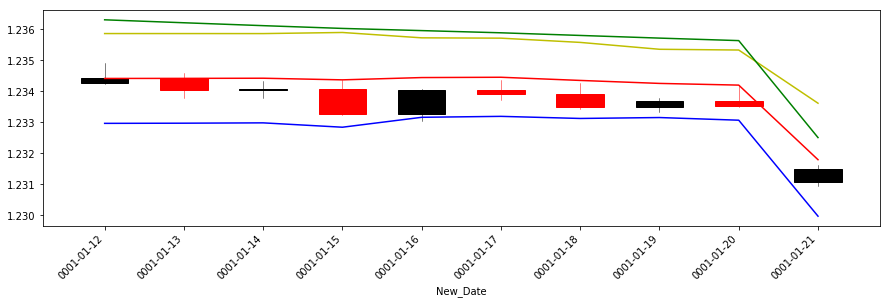

In [735]:
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12
hourFormatter = DateFormatter('%h')

fig1 = plt.figure(figsize=(15,15))
ax10 = plt.subplot(3,1,1)
fig1.subplots_adjust(bottom=0.2)
# ax10.xaxis.set_major_locator(mondays)
# ax10.xaxis.set_minor_locator(alldays)
# ax10.xaxis.set_major_formatter(dayFormatter)
ax10.xaxis.set_minor_formatter(hourFormatter)

### Charting by actual dates on X asis:
candlestick_ohlc(ax10, zip(mdates.date2num(min_1_analyzed_df_candle_chart.index),
                         min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
                         min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)
### Charting by intigers (converted to dates on the chart) on X asis:
# candlestick_ohlc(ax10, zip(min_1_analyzed_df_candle_chart.index,
#                           min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
#                           min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)
                           
min_1_analyzed_df_candle_chart["Middle_Band"].plot(ax=ax10, color="r")
min_1_analyzed_df_candle_chart["Upper_Band"].plot(ax=ax10, color="y")
min_1_analyzed_df_candle_chart["Lower_Band"].plot(ax=ax10, color="b")
min_1_analyzed_df_candle_chart["Seventy_SMA"].plot(ax=ax10, color="g")

ax10.xaxis_date()
ax10.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

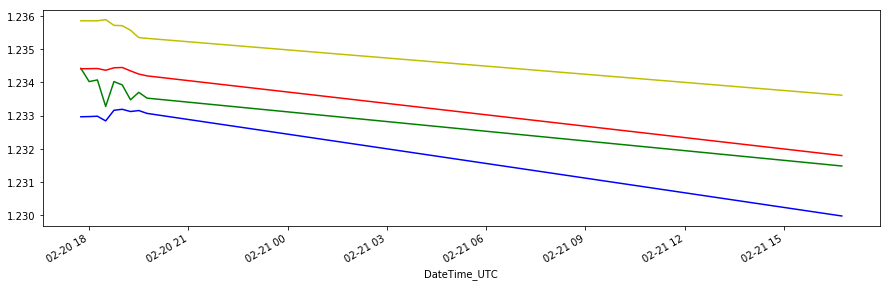

In [736]:
#%matplotlib inline

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(3,1,1)
# Close price
min_1_analyzed_df_line_chart["Close"].plot(ax=ax1, color="g")
#min_1_analyzed_df.iloc[rows_to_chart,3:4].plot(ax=ax1, color="g")
ax2 = plt.subplot(3,1,1)
# Middle band (20SMA)
min_1_analyzed_df_line_chart["Middle_Band"].plot(ax=ax1, color="r")
#min_1_analyzed_df.iloc[rows_to_chart,6:7].plot(ax=ax1, color="r")
ax3 = plt.subplot(3,1,1)
# Upper band
min_1_analyzed_df_line_chart["Upper_Band"].plot(ax=ax1, color="y")
#min_1_analyzed_df.iloc[rows_to_chart,7:8].plot(ax=ax1, color="y")
# Lower band
min_1_analyzed_df_line_chart["Lower_Band"].plot(ax=ax1, color="b")
#min_1_analyzed_df.iloc[rows_to_chart,8:9].plot(ax=ax1, color="b")
plt.show()

## Calculating Factor's Profit and Loss

In [737]:
# class long_or_short_cls:
#     # Long = 0
#     # Short = 1
#     long_or_short = 0

class Pos_Open:
    is_position_open = False
    @classmethod
    def position_opened(cls, opened):
        if opened == True:
            cls.is_position_open = True
        else:
            cls.is_position_open = False
        
class Prft_lss_calc:
    entry_value = 0
    exit_value = 0
    prft_lss = 0
    stop_price_at_entry = 0
    
    def round_down(self, n):
        return (np.floor(n*100))/100
        
    @classmethod
    def add_to_pos(cls, high_price, low_price, upper_band, lower_band, long_or_short):
        #For long:
        if long_or_short == "long":
            cls.entry_value = (lower_band+0.0001)*Trade_Size.size 
            cls.stop_price_at_entry = low_price
        #For short:
        else:
            cls.entry_value = (upper_band-0.0001)*Trade_Size.size
            cls.stop_price_at_entry = high_price

    def prft_lss_cal_stopped_out(self, price, long_or_short):
        self.exit_value = price*Trade_Size.size
        # for long
        if long_or_short == "long":
            self.prft_lss = self.round_down(self.exit_value - Prft_lss_calc.entry_value)
        # for short
        else:
            self.prft_lss = self.round_down(Prft_lss_calc.entry_value - self.exit_value)
        return self.prft_lss
    
    def prft_lss_cal_took_prft(self, price, long_or_short):
        self.exit_value = price*Trade_Size.size
        # for long
        if long_or_short == "long":
            self.prft_lss = self.round_down(self.exit_value - Prft_lss_calc.entry_value)
        # for short
        else:
            self.prft_lss = self.round_down(Prft_lss_calc.entry_value - self.exit_value)
        return self.prft_lss
        
def trd_price_and_prft(row):
    
    p_l_calc = Prft_lss_calc()
    
    if (row.Action == "Entered") & (Pos_Open.is_position_open == False):
        p_l_calc.add_to_pos(row.High, row.Low, row.Upper_Band, row.Lower_Band, row.Long_Short)
        Pos_Open.position_opened(True)
        return [p_l_calc.entry_value,0]
    
    elif ((row.Action == "Took Profit") | (row.Action == "Stopped Out")) & (Pos_Open.is_position_open == True):
#         Prft_lss_calc.close_pos(row.High)
        Pos_Open.position_opened(False)
        # if Took Profit
        if row.Action == "Took Profit":
            # for long:
            if row.Long_Short == "long":
                pric = row.Middle_Band+0.0009
            # for short:
            else:
                pric = row.Middle_Band-0.0009
            #list_to_return = 
            return [pric, p_l_calc.prft_lss_cal_took_prft(pric, row.Long_Short)]
        # if Stopped Out
        else:
            # for long:
            if row.Long_Short == "long":
                stopped_pric = p_l_calc.stop_price_at_entry - 0.0006
            # for short:
            else:
                stopped_pric = p_l_calc.stop_price_at_entry + 0.0006
            #list_to_return_1 = 
            return [stopped_pric, p_l_calc.prft_lss_cal_stopped_out(stopped_pric, row.Long_Short)]
    
    else:
        return[np.NaN,0]

min_1_analyzed_df["Trade_Prc_and_Prft"] = min_1_analyzed_df.apply(trd_price_and_prft, axis=1)

# def extract_prft_lss(Trade_Prc_and_Prft):
#     if len(Split_Action) > 1:
#         return Split_Action[-1]
#     else:
#         return np.nan

min_1_analyzed_df["Trade_Prft_Lss"] = min_1_analyzed_df["Trade_Prc_and_Prft"].apply(lambda x: x[1])
min_1_analyzed_df.head(80)

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-19 18:30:00  1.240950  1.241075  1.240900  1.240925     1.239424   
2018-02-19 18:45:00  1.240925  1.241075  1.240875  1.240875     1.239604   
2018-02-19 19:00:00  1.240875  1.241175  1.240875  1.241025     1.239754   
2018-02-19 19:15:00  1.241025  1.241050  1.240950  1.240950     1.239920   
2018-02-19 19:30:00  1.240950  1.241075  1.240825  1.241075     1.240095   
2018-02-19 19:45:00  1.241075  1.241225  1.240675  1.240800     1.240261   
2018-02-20 16:45:00  1.234275  1.235075  1.233625  1.234825     1.234371   
2018-02-20 17:00:00  1.234825  1.235275  1.234075  1.234975     1.234383   
2018-02-20 17:15:00  1.234975  1.235775  1.234975  1.235425     1.234415   
2018-02-20 17:30:00  1.235425  1.235575  1.234275  1.234275     1.234423   
2018-02-20 17:45:00  1.234275  1.234900  1.234225  1.234425     1.234413   
2018-02-20 18:00:00  1.234425  1.234575  1.233775  1.234025     1.234415   
2018-02-20 18:15:00  1.234025  1.234325  1.233775  1.234075     1.234420   
2018-02-20 18:30:00  1.234075  1.234375  1.233225  1.233275     1.234368   
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-20 19:00:00  1.234025  1.234375  1.233725  1.233925     1.234451   
2018-02-20 19:15:00  1.233925  1.234275  1.233425  1.233475     1.234349   
2018-02-20 19:30:00  1.233475  1.233775  1.233325  1.233700     1.234253   
2018-02-20 19:45:00  1.233700  1.234175  1.233500  1.233525     1.234198   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 17:00:00  1.231475  1.231875  1.231225  1.231450     1.231769   
2018-02-21 17:15:00  1.231450  1.231725  1.231125  1.231625     1.231786   
2018-02-21 17:30:00  1.231625  1.231975  1.231275  1.231825     1.231856   
2018-02-21 17:45:00  1.231825  1.232725  1.231625  1.232725     1.231969   
2018-02-21 18:00:00  1.232725  1.232725  1.232275  1.232675     1.232044   
2018-02-21 18:15:00  1.232675  1.232775  1.232375  1.232475     1.232123   
2018-02-21 18:30:00  1.232475  1.232725  1.231775  1.232025     1.232150   
2018-02-21 18:45:00  1.232025  1.232775  1.231975  1.232425     1.232169   
2018-02-21 19:00:00  1.232425  1.235975  1.231525  1.234600     1.232273   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
...                       ...       ...       ...       ...          ...   
2018-02-23 18:00:00  1.230625  1.230625  1.229625  1.229775     1.230016   
2018-02-23 18:15:00  1.229775  1.229825  1.229325  1.229475     1.230021   
2018-02-23 18:30:00  1.229475  1.229675  1.229025  1.229225     1.229983   
2018-02-23 18:45:00  1.229225  1.229775  1.229050  1.229425     1.229965   
2018-02-23 19:00:00  1.229425  1.229750  1.229300  1.229525     1.229923   
2018-02-23 19:15:00  1.229525  1.229675  1.228925  1.228925     1.229883   
2018-02-23 19:30:00  1.228925  1.229275  1.228925  1.228975     1.229859   
2018-02-23 19:45:00  1.228975  1.229700  1.228875  1.229625     1.229819   
2018-02-26 16:45:00  1.230825  1.230975  1.229425  1.229525     1.230937   
2018-02-26 17:00:00  1.229525  1.229625  1.229025  1.229625     1.230770   
2018-02-26 17:15:00  1.229625  1.230125  1.229525  1.229975     1.230625   
2018-02-26 17:30:00  1.229975  1.230175  1.229725  1.230075     1.230487   
2018-02-26 17:45:00  1.230075  1.230875  1.230025  1.230775     1.230422   
2018-02-26 18:00:00  1.230775  1.231175  1.230725  1.230725     1.230360   
2018-02-26 18:15:00  1.230725  1.230875  1.230325  1.230575     1.230275   
2018-02-26 18:30:00  1.230575  1.230775  1.230525  1.230675     1.230217   
2018-02-26 18:45:00  1.230675  1.231125  1.230225  1.231025     1.230245   
2018-02-26 19:00:00  1.231025  1.231125  1.230675  1.230725     1.230225   
2018-02-26 19:15:00  1.230725  1.231050  1.230625  1.231025     1.230262   
2018-02-26 19:30:00  1.231025  1.231275  1.230925  1.231175     1.230297 

In [738]:
#min_1_analyzed_df[min_1_analyzed_df["Period_Number"] > 240]

In [739]:
min_1_analyzed_df_dist_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
min_1_analyzed_df_dist_analysis
# min_1_analyzed_df_dist_analysis[min_1_analyzed_df_dist_analysis["Trade_Prft_Lss"]>=0]

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-20 18:45:00  1.233275  1.234075  1.233025  1.234025     1.234441   
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 19:15:00  1.234600  1.235975  1.232375  1.232475     1.232235   
2018-02-21 19:45:00  1.232525  1.232525  1.229975  1.230225     1.232100   
2018-03-01 16:45:00  1.221925  1.222225  1.220925  1.221550     1.218135   
2018-03-01 19:15:00  1.220125  1.222925  1.220075  1.222625     1.219717   
2018-03-01 19:30:00  1.222625  1.223725  1.222475  1.223350     1.220039   
2018-03-01 19:45:00  1.223350  1.225875  1.223225  1.225525     1.220447   
2018-03-12 17:15:00  1.233025  1.233550  1.232925  1.233075     1.231390   
2018-03-12 18:30:00  1.233525  1.234425  1.233525  1.234125     1.232245   
2018-03-12 18:45:00  1.234125  1.234575  1.233625  1.233725     1.232393   
2018-03-13 15:45:00  1.239675  1.240075  1.239325  1.239825     1.236329   
2018-03-15 16:00:00  1.231975  1.232425  1.231600  1.232175     1.233855   
2018-03-15 18:30:00  1.231675  1.231825  1.230625  1.230875     1.232588   
2018-03-19 17:00:00  1.233350  1.234525  1.233325  1.233800     1.231946   
2018-03-19 18:00:00  1.234825  1.235075  1.234275  1.234675     1.232686   
2018-03-19 19:00:00  1.235875  1.235875  1.235075  1.235350     1.233426   
2018-03-20 15:45:00  1.227875  1.228275  1.226975  1.227025     1.228285   
2018-03-20 16:30:00  1.225825  1.226825  1.225725  1.226200     1.227678   
2018-03-20 16:45:00  1.226200  1.226275  1.224550  1.225400     1.227466   
2018-03-20 17:00:00  1.225400  1.225975  1.225325  1.225725     1.227311   
2018-03-21 18:00:00  1.228150  1.231650  1.225125  1.230975     1.227901   
2018-03-21 18:15:00  1.230975  1.232025  1.229650  1.230000     1.227965   
2018-03-21 18:45:00  1.230500  1.233175  1.230475  1.232975     1.228251   
2018-03-21 19:00:00  1.232975  1.233975  1.232800  1.233900     1.228523   
2018-03-21 19:30:00  1.233275  1.234525  1.233275  1.234400     1.229049   
2018-03-22 16:15:00  1.229300  1.231675  1.228525  1.231425     1.231386   
2018-03-22 19:30:00  1.231325  1.231825  1.230925  1.231450     1.230678   
2018-03-22 19:45:00  1.231450  1.232275  1.231425  1.231825     1.230724   
2018-03-23 15:45:00  1.235025  1.236275  1.235025  1.235875     1.234314   
...                       ...       ...       ...       ...          ...   
2019-01-29 19:45:00  1.143025  1.143475  1.142575  1.142825     1.142520   
2019-01-30 19:00:00  1.141775  1.147375  1.141750  1.146975     1.142134   
2019-01-30 19:30:00  1.147075  1.149925  1.147075  1.149875     1.142856   
2019-01-31 16:45:00  1.145375  1.145425  1.144975  1.145325     1.148087   
2019-01-31 17:15:00  1.144575  1.144675  1.143575  1.144025     1.147615   
2019-02-04 18:30:00  1.143350  1.143475  1.142925  1.143000     1.143380   
2019-02-12 16:45:00  1.131825  1.131875  1.131475  1.131575     1.129764   
2019-02-12 18:00:00  1.131975  1.133975  1.131975  1.133950     1.130606   
2019-02-12 18:15:00  1.133950  1.133975  1.133375  1.133500     1.130815   
2019-02-13 16:45:00  1.128475  1.128975  1.128425  1.128775     1.129742   
2019-02-13 17:15:00  1.128525  1.128525  1.127525  1.127825     1.129355   
2019-02-13 19:15:00  1.127375  1.127525  1.126675  1.127075     1.128480   
2019-02-15 18:45:00  1.129425  1.130625  1.129375  1.129975     1.127455   
2019-02-19 18:30:00  1.134925  1.134925  1.134525  1.134675     1.132965   
2019-02-20 16:45:00  1.136025  1.136975  1.136025  1.136825     1.134399   
2019-02-20 19:00:00  1.136350  1.136675  1.133675  1.134625     1.135512   
2019-02-21 17:15:00  1.132775  1.132925  1.132325  1.132675     1.134552   
2019-02-22 17:00:00  1.134075  1.135525  1.133775  1.133925     1.133660   
2019-02-25 19:30:00  1.136425  1.136475  1.136125  1.136175     1.135042   
2019-02-26 16:45:00  1.137375  1.138025  1.137225  1.137325     1.136351 

### P&L time distribution

#### Prep

In [740]:
min_1_analyzed_df_dist_analysis["Trade_Entry_Time"] = min_1_analyzed_df_dist_analysis.index
min_1_analyzed_df_dist_analysis["Trade_Entry_Time_Shifted"] = min_1_analyzed_df_dist_analysis["Trade_Entry_Time"].shift(1)
min_1_analyzed_df_dist_analysis.drop("Trade_Entry_Time",axis=1, inplace=True)
min_1_analyzed_df_dist_analysis_exists_only = min_1_analyzed_df_dist_analysis.loc[((min_1_analyzed_df_dist_analysis \
["Action"] == "Took Profit") | (min_1_analyzed_df_dist_analysis["Action"] == "Stopped Out")),:]
min_1_analyzed_df_dist_analysis_exists_only["Hour_of_Entry"] = min_1_analyzed_df_dist_analysis_exists_only \
["Trade_Entry_Time_Shifted"].apply(lambda x: x.hour)

c:\python 3.7\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\python 3.7\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
c:\python 3.7\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [741]:
min_1_analyzed_df_dist_analysis_exists_only

Open      High       Low     Close  Middle_Band  \
DateTime_UTC                                                               
2018-02-21 16:45:00  1.231075  1.231625  1.230925  1.231475     1.231789   
2018-02-21 19:45:00  1.232525  1.232525  1.229975  1.230225     1.232100   
2018-03-01 19:15:00  1.220125  1.222925  1.220075  1.222625     1.219717   
2018-03-01 19:45:00  1.223350  1.225875  1.223225  1.225525     1.220447   
2018-03-12 18:30:00  1.233525  1.234425  1.233525  1.234125     1.232245   
2018-03-13 15:45:00  1.239675  1.240075  1.239325  1.239825     1.236329   
2018-03-15 18:30:00  1.231675  1.231825  1.230625  1.230875     1.232588   
2018-03-19 18:00:00  1.234825  1.235075  1.234275  1.234675     1.232686   
2018-03-20 15:45:00  1.227875  1.228275  1.226975  1.227025     1.228285   
2018-03-20 16:45:00  1.226200  1.226275  1.224550  1.225400     1.227466   
2018-03-21 18:00:00  1.228150  1.231650  1.225125  1.230975     1.227901   
2018-03-21 18:45:00  1.230500  1.233175  1.230475  1.232975     1.228251   
2018-03-21 19:30:00  1.233275  1.234525  1.233275  1.234400     1.229049   
2018-03-22 19:30:00  1.231325  1.231825  1.230925  1.231450     1.230678   
2018-03-23 15:45:00  1.235025  1.236275  1.235025  1.235875     1.234314   
2018-03-23 18:45:00  1.236675  1.237325  1.236625  1.236750     1.235585   
2018-03-27 19:45:00  1.239575  1.240050  1.239475  1.239675     1.240559   
2018-03-28 18:15:00  1.231175  1.231225  1.230075  1.231025     1.233997   
2018-03-29 15:45:00  1.228775  1.229025  1.228375  1.228775     1.231394   
2018-03-29 18:45:00  1.230825  1.231050  1.230325  1.230625     1.229976   
2018-04-04 18:15:00  1.228200  1.228375  1.227425  1.227525     1.229348   
2018-04-05 15:45:00  1.221975  1.223025  1.221825  1.222925     1.224660   
2018-04-09 15:45:00  1.231725  1.232075  1.231475  1.231875     1.230877   
2018-04-11 18:00:00  1.237225  1.237325  1.234775  1.235025     1.237817   
2018-04-12 15:45:00  1.231525  1.232325  1.231425  1.231775     1.231828   
2018-04-13 16:45:00  1.233525  1.234375  1.233275  1.234175     1.232474   
2018-04-16 15:45:00  1.236725  1.237275  1.236600  1.237275     1.237479   
2018-04-18 15:45:00  1.237375  1.238125  1.237125  1.237975     1.238405   
2018-04-19 15:45:00  1.234025  1.234025  1.232925  1.233625     1.237056   
2018-04-20 15:45:00  1.228025  1.228875  1.227825  1.228175     1.228730   
...                       ...       ...       ...       ...          ...   
2018-12-19 19:00:00  1.143225  1.143300  1.138325  1.138875     1.142429   
2018-12-19 19:45:00  1.138450  1.138475  1.136425  1.137175     1.141837   
2018-12-21 17:45:00  1.138975  1.139525  1.138475  1.138575     1.140501   
2018-12-26 18:30:00  1.136025  1.136475  1.135725  1.136450     1.138955   
2018-12-28 17:15:00  1.144475  1.144475  1.143875  1.144175     1.144892   
2019-01-04 16:45:00  1.141475  1.141775  1.140850  1.140875     1.138990   
2019-01-09 16:45:00  1.153625  1.153625  1.152375  1.152425     1.149042   
2019-01-10 16:45:00  1.151225  1.152175  1.151225  1.151675     1.152510   
2019-01-10 17:45:00  1.150575  1.151275  1.149725  1.150600     1.152007   
2019-01-10 18:15:00  1.151025  1.151375  1.148475  1.149075     1.151650   
2019-01-11 16:45:00  1.146725  1.147975  1.146725  1.147825     1.149865   
2019-01-16 16:45:00  1.140475  1.141075  1.140375  1.140775     1.139572   
2019-01-18 16:45:00  1.136475  1.136625  1.135725  1.136225     1.138377   
2019-01-24 16:45:00  1.134525  1.134575  1.132075  1.132175     1.135036   
2019-01-24 19:00:00  1.130400  1.130625  1.128925  1.129225     1.133182   
2019-01-30 19:00:00  1.141775  1.147375  1.141750  1.146975     1.142134   
2019-01-31 16:45:00  1.145375  1.145425  1.144975  1.145325     1.148087   
2019-02-04 18:30:00  1.143350  1.143475  1.142925  1.143000     1.143380   
2019-02-12 18:00:00  1.131975  1.133975  1.131975  1.133950     1.130606   
2019-02-13 16:45:00  1.128475  1.128975  1.128425  1.128775     1.129742 

#### Time distribution of Profits

AxesSubplot(0.125,0.125;0.775x0.755)


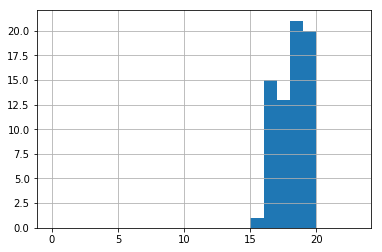

In [742]:
print(min_1_analyzed_df_dist_analysis_exists_only[min_1_analyzed_df_dist_analysis_exists_only["Trade_Prft_Lss"]>0] \
["Hour_of_Entry"].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,23]))

#### Time distribution of losses

AxesSubplot(0.125,0.125;0.775x0.755)


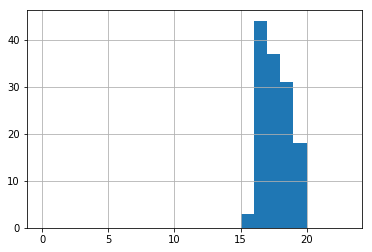

In [743]:
print(min_1_analyzed_df_dist_analysis_exists_only[min_1_analyzed_df_dist_analysis_exists_only["Trade_Prft_Lss"]<=0] \
["Hour_of_Entry"].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]))

## Result (P & L)

# of Trades: 203
        Count    Average
Loss      133 -21.894211
Profit     70  76.191857
Gross P&L: 2421.5000000000005 (12.107500000000002%)
Commission: 406
Slippage: 406.0
Net P&L: 1609.5000000000005 (8.047500000000001%)


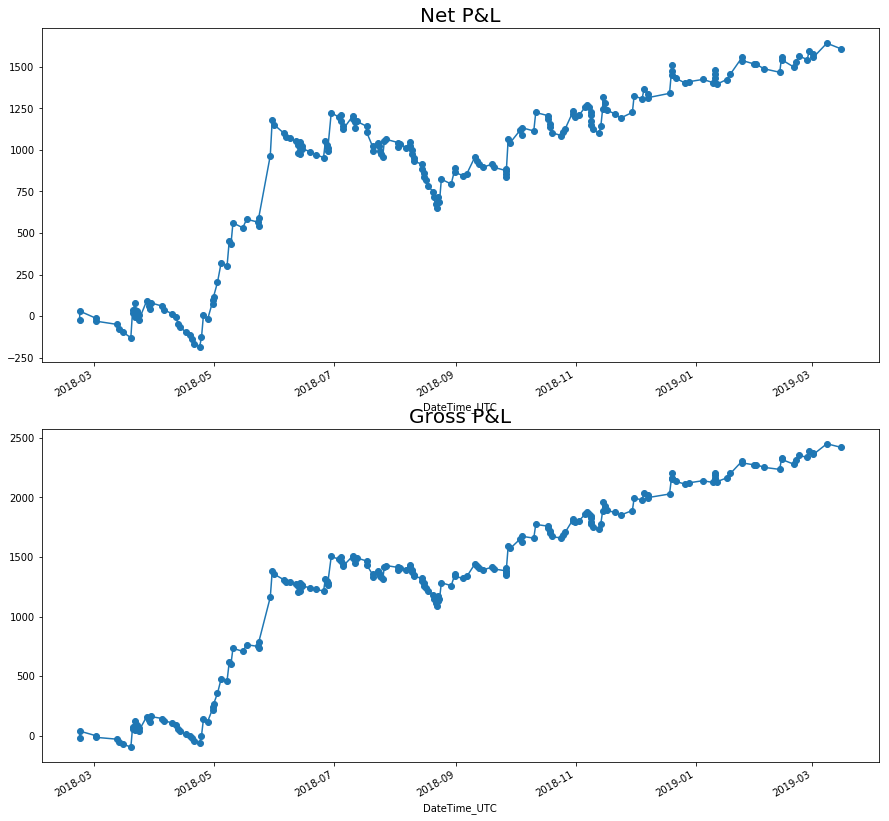

In [744]:
# Gross P&L:
gross_absolute_profit_loss = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].sum()
gross_percent_profit_loss = (gross_absolute_profit_loss/Trade_Size.size)*100

# Commission:
commission = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()*2

#Slippage:
slippage = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()*(Trade_Size.size/10000)

# Net P&L:
net_absolute_profit_loss = gross_absolute_profit_loss - commission - slippage
net_percent_profit_loss = (net_absolute_profit_loss/Trade_Size.size)*100

# Number of trades:
num_of_trades = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()

profit_vs_loss = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"] > 0
profit_vs_loss.replace({True:"Profit",False:"Loss"}, inplace=True)
s = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"]
P_N_L_Stats = pd.DataFrame({"Count":profit_vs_loss.value_counts().values,"Average":[s[s<0].mean(), 
s[s>0].mean()]},index=profit_vs_loss.value_counts().index)

print("# of Trades: {}".format(num_of_trades))
print(P_N_L_Stats)
print("Gross P&L: {} ({}%)".format(gross_absolute_profit_loss,gross_percent_profit_loss))
print("Commission: {}".format(commission))
print("Slippage: {}".format(slippage))
print("Net P&L: {} ({}%)".format(net_absolute_profit_loss,net_percent_profit_loss))

# Charting P&L:
pnl_chart_df = min_1_analyzed_df["Trade_Prft_Lss"].replace(0,np.NaN)
pnl_chart_df_cumsum = pnl_chart_df[pnl_chart_df < 1000000000].cumsum()
pnl_chart_df_less_comm_and_slip = pnl_chart_df - 2 - Trade_Size.size/10000
pnl_chart_df_less_comm_and_slip_cumsum = pnl_chart_df_less_comm_and_slip[pnl_chart_df_less_comm_and_slip < 1000000000].cumsum()

fig1 = plt.figure(figsize=(15,15))
ax4 = plt.subplot(2,1,1)
ax4.set_title("Net P&L", fontsize=20)
pnl_chart_df_less_comm_and_slip_cumsum.plot(ax=ax4, linestyle="-", marker="o")
ax5 = plt.subplot(2,1,2)
ax5.set_title("Gross P&L", fontsize=20)
pnl_chart_df_cumsum.plot(ax=ax5, linestyle="-", marker="o")
plt.show()
# ax2 = plt.subplot(3,1,1)
# min_1_analyzed_df["SMA10"].head(100).plot(ax=ax1, color="r")
# ax3 = plt.subplot(3,1,1)
# min_1_analyzed_df["SMA20"].head(100).plot(ax=ax1, color="y")